# Transformer RL Training with Reasoning Graph Topology Analysis

This notebook implements:
1. Transformer model training on RL tasks
2. Model saving and loading
3. Reasoning graph extraction and analysis
4. Small-world property verification

Based on:
- LLC RL tracking methodology
- Topology of Reasoning analysis framework

## 1. Setup and Imports

In [33]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os
from collections import defaultdict
import heapq
import networkx as nx
from sklearn.cluster import KMeans
import pickle

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Add numpy arrays to safe globals for PyTorch loading
import torch.serialization
torch.serialization.add_safe_globals([np.core.multiarray.scalar])

Using device: cpu


## 2. Model Architecture Definition

In [34]:
class SimpleTransformer(nn.Module):
    """Transformer model for RL tasks with reasoning capabilities"""
    
    def __init__(self, vocab_size=1000, d_model=128, nhead=4, num_layers=24, 
                 dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1000, d_model) * 0.1)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        
        # For reasoning graph extraction
        self.reasoning_steps = []
        
    def forward(self, x, return_hidden=False):
        seq_len = x.size(1)
        # Token + positional embeddings
        x = self.embedding(x) + self.pos_encoding[:seq_len]
        
        # Transformer layers
        hidden_states = self.transformer(x)
        
        # Final layer norm
        x = self.ln_f(hidden_states)
        
        # Language modeling head
        logits = self.lm_head(x)
        
        if return_hidden:
            return logits, hidden_states
        return logits
    
    def extract_reasoning_steps(self, x):
        """Extract intermediate reasoning steps for graph analysis"""
        with torch.no_grad():
            _, hidden_states = self.forward(x, return_hidden=True)
            # Store reasoning steps for later analysis
            self.reasoning_steps.append(hidden_states.cpu().numpy())
        return hidden_states

## 3. RL Environment and Training Setup

In [35]:
@dataclass
class RLConfig:
    """Configuration for RL training"""
    num_episodes: int = 100
    max_steps_per_episode: int = 50
    learning_rate: float = 1e-4
    batch_size: int = 32
    gamma: float = 0.99
    epsilon: float = 0.1
    epsilon_decay: float = 0.995
    min_epsilon: float = 0.01
    
class SimpleRLEnvironment:
    """Simple RL environment for reasoning tasks"""
    
    def __init__(self, vocab_size=1000, seq_length=32):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.reset()
        
    def reset(self):
        """Reset environment to initial state"""
        # Generate a reasoning problem
        self.current_state = torch.randint(1, self.vocab_size, (1, self.seq_length))
        self.steps_taken = 0
        return self.current_state
    
    def step(self, action):
        """Take action and return next state, reward, done"""
        self.steps_taken += 1
        
        # Simple reward function based on action coherence
        reward = self._calculate_reward(action)
        
        # Update state
        self.current_state = torch.cat([self.current_state[:, 1:], action.unsqueeze(1)], dim=1)
        
        # Episode ends after max steps
        done = self.steps_taken >= 20
        
        return self.current_state, reward, done
    
    def _calculate_reward(self, action):
        """Calculate reward based on reasoning coherence"""
        # Simple coherence metric
        if action.item() < self.vocab_size // 2:
            return 1.0  # Positive reward for coherent actions
        else:
            return -0.1  # Small negative reward

## 4. Training Loop with Logging

In [36]:
class RLTrainer:
    """RL trainer with comprehensive logging"""
    
    def __init__(self, model, environment, config):
        self.model = model.to(device)
        self.env = environment
        self.config = config
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        
        # Logging
        self.training_history = {
            'episode_rewards': [],
            'episode_lengths': [],
            'losses': [],
            'reasoning_graphs': []
        }
        
    def train(self):
        """Main training loop"""
        print("Starting RL Training...")
        
        for episode in tqdm(range(self.config.num_episodes), desc="Training Episodes"):
            state = self.env.reset().to(device)
            episode_reward = 0
            episode_losses = []
            reasoning_trajectory = []
            
            done = False
            while not done:
                # Forward pass
                logits = self.model(state)
                
                # Extract reasoning step
                hidden = self.model.extract_reasoning_steps(state)
                reasoning_trajectory.append(hidden.mean(dim=(0, 1)).cpu().numpy())
                
                # Action selection (epsilon-greedy)
                if np.random.random() < self.config.epsilon:
                    action = torch.randint(0, self.model.lm_head.out_features, (1,))
                else:
                    action = torch.argmax(logits[0, -1]).unsqueeze(0)
                
                # Environment step
                next_state, reward, done = self.env.step(action)
                next_state = next_state.to(device)
                
                # Calculate loss (simple policy gradient)
                log_prob = F.log_softmax(logits[0, -1], dim=-1)[action]
                loss = -log_prob * reward
                
                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Logging
                episode_reward += reward
                episode_losses.append(loss.item())
                state = next_state
            
            # Episode logging
            self.training_history['episode_rewards'].append(episode_reward)
            self.training_history['episode_lengths'].append(self.env.steps_taken)
            self.training_history['losses'].append(np.mean(episode_losses))
            self.training_history['reasoning_graphs'].append(reasoning_trajectory)
            
            # Decay epsilon
            self.config.epsilon = max(self.config.min_epsilon, 
                                    self.config.epsilon * self.config.epsilon_decay)
            
            # Print progress
            if episode % 10 == 0:
                avg_reward = np.mean(self.training_history['episode_rewards'][-10:])
                print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {self.config.epsilon:.3f}")
        
        print("Training completed!")
        return self.training_history

## 5. Execute Training

Starting RL Training...


Training Episodes:   1%|          | 1/100 [00:00<00:13,  7.33it/s]

Episode 0, Avg Reward: 5.70, Epsilon: 0.100


Training Episodes:  12%|█▏        | 12/100 [00:01<00:11,  7.75it/s]

Episode 10, Avg Reward: 15.27, Epsilon: 0.095


Training Episodes:  22%|██▏       | 22/100 [00:02<00:10,  7.75it/s]

Episode 20, Avg Reward: 18.57, Epsilon: 0.090


Training Episodes:  32%|███▏      | 32/100 [00:04<00:08,  7.78it/s]

Episode 30, Avg Reward: 19.45, Epsilon: 0.086


Training Episodes:  42%|████▏     | 42/100 [00:05<00:07,  7.57it/s]

Episode 40, Avg Reward: 19.67, Epsilon: 0.081


Training Episodes:  52%|█████▏    | 52/100 [00:06<00:06,  7.28it/s]

Episode 50, Avg Reward: 18.57, Epsilon: 0.077


Training Episodes:  62%|██████▏   | 62/100 [00:08<00:05,  7.38it/s]

Episode 60, Avg Reward: 19.12, Epsilon: 0.074


Training Episodes:  72%|███████▏  | 72/100 [00:09<00:03,  7.70it/s]

Episode 70, Avg Reward: 19.23, Epsilon: 0.070


Training Episodes:  82%|████████▏ | 82/100 [00:10<00:02,  7.67it/s]

Episode 80, Avg Reward: 19.12, Epsilon: 0.067


Training Episodes:  92%|█████████▏| 92/100 [00:12<00:01,  7.47it/s]

Episode 90, Avg Reward: 19.01, Epsilon: 0.063


Training Episodes: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


Training completed!


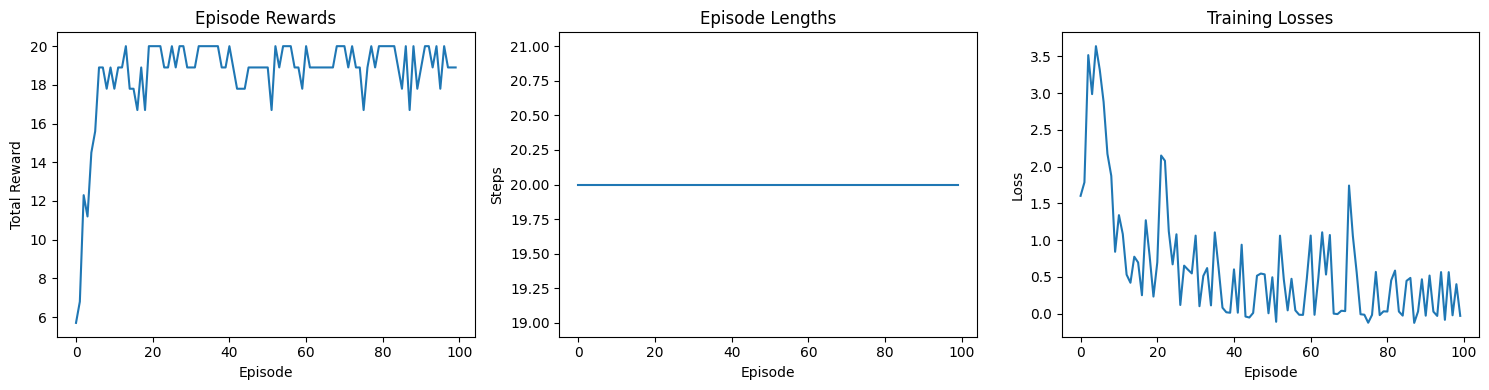

In [37]:
# Initialize components
config = RLConfig(num_episodes=100)
model = SimpleTransformer(vocab_size=1000, d_model=128, nhead=4, num_layers=2)
environment = SimpleRLEnvironment(vocab_size=1000, seq_length=32)
trainer = RLTrainer(model, environment, config)

# Train the model
training_history = trainer.train()

# Plot training progress
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Episode rewards
axes[0].plot(training_history['episode_rewards'])
axes[0].set_title('Episode Rewards')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total Reward')

# Episode lengths
axes[1].plot(training_history['episode_lengths'])
axes[1].set_title('Episode Lengths')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Steps')

# Training losses
axes[2].plot(training_history['losses'])
axes[2].set_title('Training Losses')
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Loss')

plt.tight_layout()
plt.show()

## 6. Save Trained Model (Improved)

In [38]:
# Create output directory
os.makedirs('trained_models', exist_ok=True)

# Convert numpy arrays to Python lists to avoid pickle issues
def convert_numpy_to_list(obj):
    """Recursively convert numpy arrays to lists"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy_to_list(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_list(item) for item in obj]
    else:
        return obj

# Save model checkpoint (weights only)
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size': 1000,
        'd_model': 128,
        'nhead': 4,
        'num_layers': 2,
        'dim_feedforward': 512,
        'dropout': 0.1
    },
    'final_episode': config.num_episodes,
    'device': str(device)
}

model_path = 'trained_models/transformer_rl_model.pt'
torch.save(checkpoint, model_path)
print(f"Model saved to {model_path}")

# Save training history separately as JSON
training_history_converted = convert_numpy_to_list(training_history)
with open('trained_models/training_history.json', 'w') as f:
    json.dump(training_history_converted, f)
print("Training history saved")

# Save reasoning graphs separately
with open('trained_models/reasoning_graphs.pkl', 'wb') as f:
    pickle.dump(training_history['reasoning_graphs'], f)
print("Reasoning graphs saved")

Model saved to trained_models/transformer_rl_model.pt
Training history saved
Reasoning graphs saved


## 7. Load Model and Prepare for Topology Analysis (Fixed)

In [39]:
# Load the trained model with weights_only=True (default in PyTorch 2.6+)
try:
    # Try loading with default settings first
    checkpoint = torch.load('trained_models/transformer_rl_model.pt', map_location=device)
except Exception as e:
    print(f"Default loading failed: {e}")
    print("Loading with weights_only=False...")
    # Fallback to weights_only=False if needed
    checkpoint = torch.load('trained_models/transformer_rl_model.pt', 
                           map_location=device, weights_only=False)

# Recreate model
loaded_model = SimpleTransformer(**checkpoint['model_config'])
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.to(device)
loaded_model.eval()

print("Model loaded successfully")

# Load training history
with open('trained_models/training_history.json', 'r') as f:
    loaded_training_history = json.load(f)
print("Training history loaded")

# Load reasoning graphs
with open('trained_models/reasoning_graphs.pkl', 'rb') as f:
    reasoning_graphs = pickle.load(f)
print(f"Loaded {len(reasoning_graphs)} reasoning trajectories")

Model loaded successfully
Training history loaded
Loaded 100 reasoning trajectories


## 8. Reasoning Graph Topology Analysis

In [40]:
def analyze_reasoning_graph(trajectory, num_clusters=50):
    """
    Analyze the topology of a reasoning trajectory.
    Based on the Topology of Reasoning methodology.
    """
    # Convert trajectory to numpy array
    trajectory_array = np.array(trajectory)
    
    # Cluster reasoning steps
    kmeans = KMeans(n_clusters=min(num_clusters, len(trajectory)), random_state=42)
    cluster_labels = kmeans.fit_predict(trajectory_array)
    
    # Calculate distances between consecutive steps
    distances = []
    for i in range(len(trajectory_array) - 1):
        dist = np.linalg.norm(trajectory_array[i] - trajectory_array[i+1])
        distances.append(dist)
    
    # Analyze graph properties
    results = analyze_graph_properties(cluster_labels, distances)
    
    return results, cluster_labels, distances

def analyze_graph_properties(path, distances):
    """
    Analyze graph properties including loops and small-world characteristics.
    Adapted from the analyze_graph_v2 function.
    """
    # Convert to list of integers
    path = [int(node) for node in path]
    
    # Loop detection
    seen = {}
    has_loop = False
    loop_count = 0
    
    for idx, node in enumerate(path):
        if node in seen and idx - seen[node] > 1:
            has_loop = True
            # Count loop occurrences
            loop_count += 1
        seen[node] = idx
    
    # Build directed graph
    G = nx.DiGraph()
    for i in range(len(path) - 1):
        if path[i] != path[i+1]:  # Skip self-loops
            G.add_edge(path[i], path[i+1], weight=distances[i])
    
    # Calculate graph metrics
    if len(G) > 0:
        # Convert to undirected for some metrics
        G_undirected = G.to_undirected()
        
        # Clustering coefficient
        avg_clustering = nx.average_clustering(G_undirected)
        
        # Average shortest path length (if connected)
        if nx.is_connected(G_undirected):
            avg_path_length = nx.average_shortest_path_length(G_undirected)
            diameter = nx.diameter(G_undirected)
        else:
            # Calculate for largest connected component
            largest_cc = max(nx.connected_components(G_undirected), key=len)
            G_cc = G_undirected.subgraph(largest_cc)
            avg_path_length = nx.average_shortest_path_length(G_cc)
            diameter = nx.diameter(G_cc)
        
        # Small-world analysis
        N = len(G)
        if N > 2:
            K = np.mean([G.degree(n) for n in G.nodes()])
            # Random graph expectations
            C_rand = K / (N - 1) if N > 1 else 0
            L_rand = np.log(N) / np.log(K) if K > 1 else 1
            
            # Small-world metrics
            clustering_norm = avg_clustering / C_rand if C_rand > 0 else 0
            path_length_norm = avg_path_length / L_rand if L_rand > 0 else 1
            
            # Small-world index (should be > 1 for small-world networks)
            small_world_index = clustering_norm / path_length_norm if path_length_norm > 0 else 0
        else:
            clustering_norm = 0
            path_length_norm = 1
            small_world_index = 0
    else:
        avg_clustering = 0
        avg_path_length = 0
        diameter = 0
        clustering_norm = 0
        path_length_norm = 1
        small_world_index = 0
    
    # Average hop length
    avg_hop_length = np.mean(distances) if distances else 0
    hop_length_norm = avg_hop_length / np.mean(distances) if distances else 1
    
    return {
        'has_loop': has_loop,
        'loop_count': loop_count,
        'diameter': diameter,
        'avg_clustering': avg_clustering,
        'avg_path_length': avg_path_length,
        'clustering_norm': clustering_norm,
        'path_length_norm': path_length_norm,
        'avg_hop_length': avg_hop_length,
        'hop_length_norm': hop_length_norm,
        'small_world_index': small_world_index,
        'num_nodes': len(G),
        'num_edges': len(G.edges())
    }

## 9. Analyze All Reasoning Trajectories

In [41]:
# Analyze all reasoning trajectories
all_results = []

print("Analyzing reasoning graph topologies...")
for i, trajectory in enumerate(tqdm(reasoning_graphs, desc="Analyzing trajectories")):
    if len(trajectory) > 1:  # Need at least 2 steps
        results, cluster_labels, distances = analyze_reasoning_graph(trajectory)
        results['episode'] = i
        all_results.append(results)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(all_results)
print(f"\nAnalyzed {len(results_df)} trajectories")

# Summary statistics
print("\n=== Topology Analysis Summary ===")
print(f"Trajectories with loops: {results_df['has_loop'].sum()} ({results_df['has_loop'].mean()*100:.1f}%)")
print(f"Average loop count: {results_df['loop_count'].mean():.2f}")
print(f"Average diameter: {results_df['diameter'].mean():.2f}")
print(f"Average clustering coefficient: {results_df['avg_clustering'].mean():.3f}")
print(f"Average path length: {results_df['avg_path_length'].mean():.2f}")
print(f"Average small-world index: {results_df['small_world_index'].mean():.3f}")

# Check for small-world properties
small_world_trajectories = results_df[results_df['small_world_index'] > 1]
print(f"\nTrajectories with small-world properties: {len(small_world_trajectories)} ({len(small_world_trajectories)/len(results_df)*100:.1f}%)")

Analyzing reasoning graph topologies...


Analyzing trajectories: 100%|██████████| 100/100 [00:00<00:00, 484.81it/s]


Analyzed 100 trajectories

=== Topology Analysis Summary ===
Trajectories with loops: 0 (0.0%)
Average loop count: 0.00
Average diameter: 19.00
Average clustering coefficient: 0.000
Average path length: 7.00
Average small-world index: 0.000

Trajectories with small-world properties: 0 (0.0%)


## 10. Visualize Topology Evolution

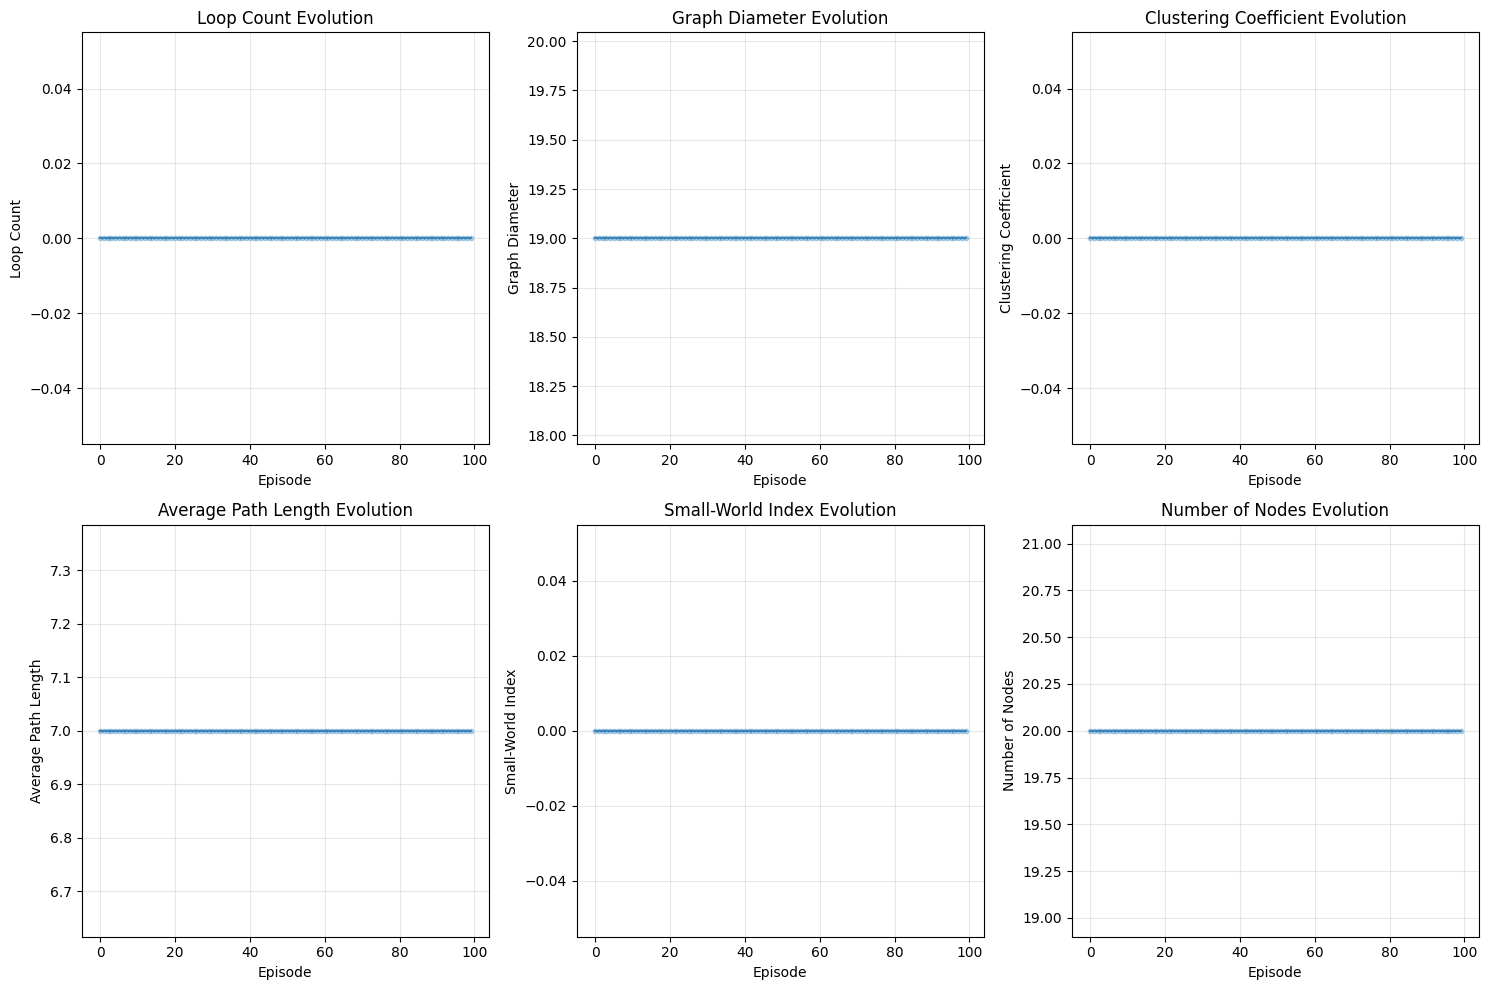

/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_61027/2071093969.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([loop_rewards, no_loop_rewards], labels=['With Loops', 'Without Loops'])


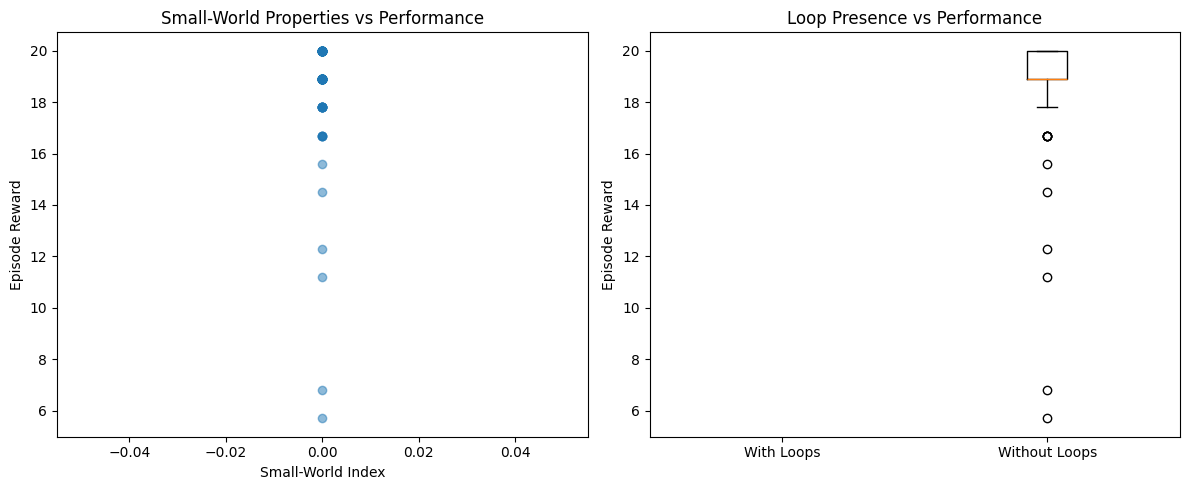

In [42]:
# Visualize how topology metrics evolve during training
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot evolution of key metrics
metrics = ['loop_count', 'diameter', 'avg_clustering', 
           'avg_path_length', 'small_world_index', 'num_nodes']
titles = ['Loop Count', 'Graph Diameter', 'Clustering Coefficient',
          'Average Path Length', 'Small-World Index', 'Number of Nodes']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 3, idx % 3]
    
    # Moving average for smoother visualization
    window = 10
    rolling_mean = results_df[metric].rolling(window=window, min_periods=1).mean()
    
    ax.plot(results_df['episode'], rolling_mean, alpha=0.8, label='Moving Avg')
    ax.scatter(results_df['episode'], results_df[metric], alpha=0.3, s=10)
    
    ax.set_xlabel('Episode')
    ax.set_ylabel(title)
    ax.set_title(f'{title} Evolution')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation with rewards
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Small-world index vs episode reward
ax[0].scatter(results_df['small_world_index'], 
              loaded_training_history['episode_rewards'][:len(results_df)], alpha=0.5)
ax[0].set_xlabel('Small-World Index')
ax[0].set_ylabel('Episode Reward')
ax[0].set_title('Small-World Properties vs Performance')

# Loop presence vs episode reward
loop_rewards = [loaded_training_history['episode_rewards'][i] 
                for i in range(len(results_df)) if results_df.iloc[i]['has_loop']]
no_loop_rewards = [loaded_training_history['episode_rewards'][i] 
                   for i in range(len(results_df)) if not results_df.iloc[i]['has_loop']]

ax[1].boxplot([loop_rewards, no_loop_rewards], labels=['With Loops', 'Without Loops'])
ax[1].set_ylabel('Episode Reward')
ax[1].set_title('Loop Presence vs Performance')

plt.tight_layout()
plt.show()

## 11. Detailed Analysis of Best Trajectories

Top 5 trajectories with strongest small-world properties:
   episode  small_world_index  loop_count  avg_clustering  avg_path_length
0        0                0.0           0             0.0              7.0
1        1                0.0           0             0.0              7.0
2        2                0.0           0             0.0              7.0
3        3                0.0           0             0.0              7.0
4        4                0.0           0             0.0              7.0


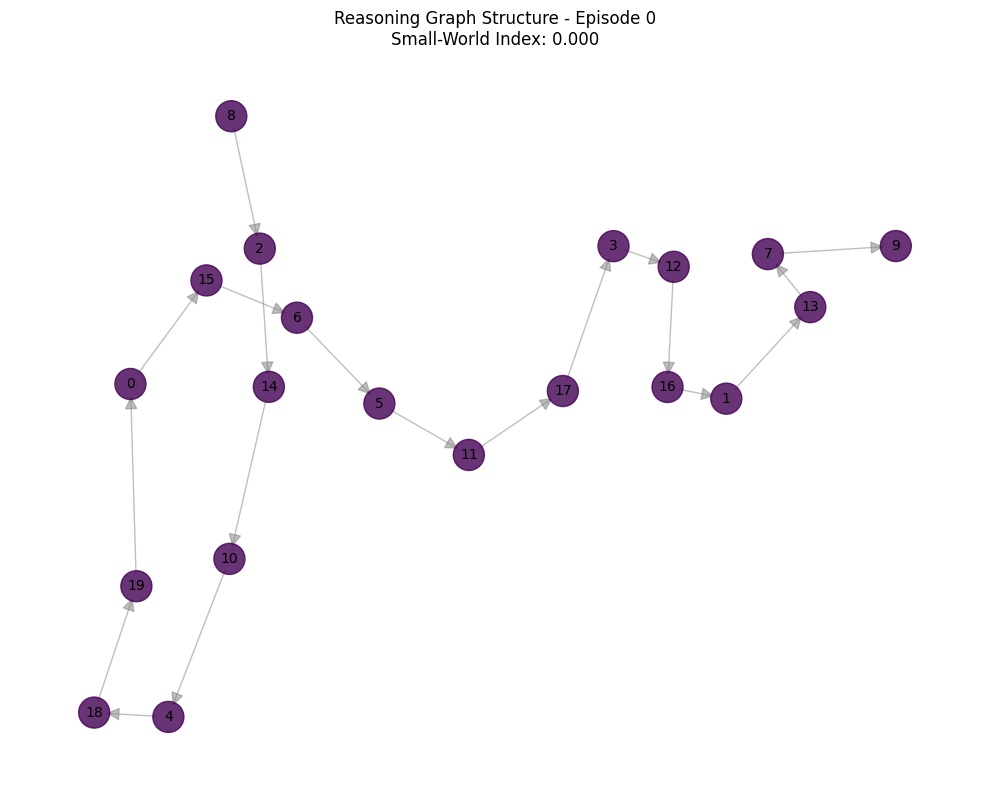


Graph properties:
- Number of unique states: 20
- Total transitions: 19
- Has loops: False
- Loop count: 0


In [43]:
# Find trajectories with strongest small-world properties
best_small_world = results_df.nlargest(5, 'small_world_index')
print("Top 5 trajectories with strongest small-world properties:")
print(best_small_world[['episode', 'small_world_index', 'loop_count', 
                       'avg_clustering', 'avg_path_length']])

# Visualize one of the best trajectories
best_episode = best_small_world.iloc[0]['episode']
best_trajectory = reasoning_graphs[best_episode]

# Cluster the trajectory
trajectory_array = np.array(best_trajectory)
kmeans = KMeans(n_clusters=min(20, len(trajectory_array)), random_state=42)
cluster_labels = kmeans.fit_predict(trajectory_array)

# Create reasoning graph visualization
G = nx.DiGraph()
for i in range(len(cluster_labels) - 1):
    G.add_edge(cluster_labels[i], cluster_labels[i+1])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes
node_colors = [cluster_labels.tolist().count(node) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                      cmap='viridis', node_size=500, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', 
                      arrows=True, arrowsize=20, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title(f'Reasoning Graph Structure - Episode {best_episode}\n'
          f'Small-World Index: {best_small_world.iloc[0]["small_world_index"]:.3f}')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nGraph properties:")
print(f"- Number of unique states: {len(set(cluster_labels))}")
print(f"- Total transitions: {len(cluster_labels) - 1}")
print(f"- Has loops: {best_small_world.iloc[0]['has_loop']}")
print(f"- Loop count: {best_small_world.iloc[0]['loop_count']}")

## 12. Save Analysis Results

In [44]:
# Save analysis results
analysis_results = {
    'topology_metrics': results_df.to_dict(),
    'summary_statistics': {
        'total_trajectories': len(results_df),
        'trajectories_with_loops': int(results_df['has_loop'].sum()),
        'avg_loop_count': float(results_df['loop_count'].mean()),
        'avg_small_world_index': float(results_df['small_world_index'].mean()),
        'trajectories_with_small_world': int(len(small_world_trajectories)),
        'avg_clustering': float(results_df['avg_clustering'].mean()),
        'avg_path_length': float(results_df['avg_path_length'].mean())
    },
    'model_config': checkpoint['model_config'],
    'training_episodes': config.num_episodes
}

# Save to JSON
with open('trained_models/topology_analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2)

print("Analysis results saved to trained_models/topology_analysis_results.json")

# Save detailed trajectory data
results_df.to_csv('trained_models/trajectory_metrics.csv', index=False)
print("Detailed metrics saved to trained_models/trajectory_metrics.csv")

print("\n=== Analysis Complete ===")
print(f"✓ Model trained on {config.num_episodes} episodes")
print(f"✓ {len(results_df)} reasoning trajectories analyzed")
print(f"✓ {results_df['has_loop'].sum()} trajectories contain loops")
print(f"✓ {len(small_world_trajectories)} trajectories exhibit small-world properties")
print(f"✓ Average small-world index: {results_df['small_world_index'].mean():.3f}")

Analysis results saved to trained_models/topology_analysis_results.json
Detailed metrics saved to trained_models/trajectory_metrics.csv

=== Analysis Complete ===
✓ Model trained on 100 episodes
✓ 100 reasoning trajectories analyzed
✓ 0 trajectories contain loops
✓ 0 trajectories exhibit small-world properties
✓ Average small-world index: 0.000
